In [1]:
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt # date type manage

import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization
import seaborn as sns             # statistical data visualization

import warnings
warnings.filterwarnings('ignore')

monkeypox_df = pd.read_csv("datasets\monkeypox.csv",)
                #  index_col='Date').drop('Cumulative_cases', axis =1)

#is there any duplicate
print("before", monkeypox_df.shape)
print("drop dup", monkeypox_df.drop_duplicates().shape)                

before (94244, 17)
drop dup (94244, 17)


In [2]:
# world, Africa, North America, South America, Europe, and Asia
# world

world_df = monkeypox_df.loc[monkeypox_df["location"] == "World"][["new_cases", "date"]]


world_df["date"]= pd.to_datetime(world_df['date'])
world_df['month'] = world_df['date'].dt.strftime('%Y-%m') # current date format ####-W##
world_df['week'] = world_df['date'].dt.strftime('%Y-W%V') # current date format ####-W##

world_df= world_df.sort_values("month")
world_df= world_df[(world_df['week']>"2023-W40") & (world_df['week']<"2024-W7")]

In [3]:
# # ## filter the original dataset to 2020 and sum # of injuries per week
# df_by_week = world_df[(world_df['date']>"2023-11-01") & (world_df['date']<"2024-08-01")].groupby(['week'])['new_cases'].sum().reset_index()
# df_by_week.head(1)

In [4]:
## filter the original dataset to 2023 and sum # of injuries per day
df_by_day = world_df[(world_df['date']>"2023-11-01") & (world_df['date']<"2024-08-01")].groupby(['date'])['new_cases'].sum().reset_index()
df_by_day.tail(1)

,date,new_cases
272,2024-07-31,188.0


In [5]:
#is there any duplicate
print("before", world_df.shape)
print("drop dup", world_df.drop_duplicates().shape)

before (374, 4)
drop dup (374, 4)


## Plot Time-Series

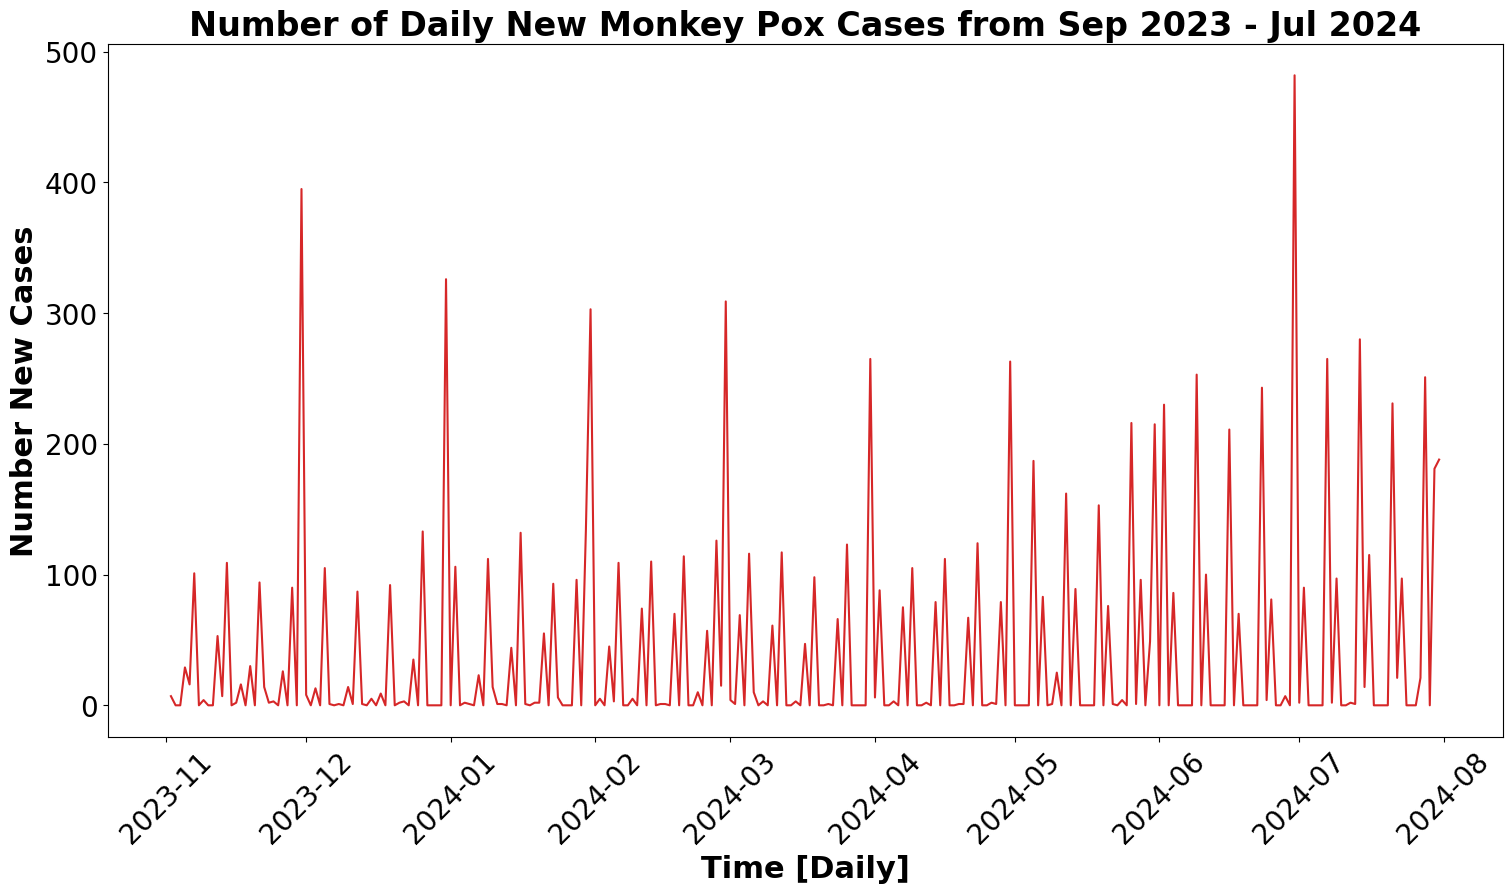

In [53]:
def plot_df(df, x, y, title="", xlabel='time-[daily]', ylabel='Number New Cases', dpi=100):
    plt.figure(figsize=(18,9), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.xlabel(xlabel=xlabel, fontsize =22, weight ='bold')
    plt.title(title, fontsize =24, weight ='bold')
    plt.ylabel(ylabel=ylabel, fontsize =22, weight ='bold')
    plt.xticks(rotation =45,fontsize =20)
    plt.yticks(fontsize =20)
    plt.show()
    
    
# plot_df(world_df, x= world_df['month'], y=world_df['new_cases'], title='Number of New Monkey Pox Cases from May 2022 - Sep 2024')

# plot_df(df_by_week, x= df_by_week['week'], y=df_by_week['new_cases'], title='Number of Weekly New Monkey Pox Cases from Jul 2023 - Sep 2024')

plot_df(df_by_day, x= df_by_day['date'], y=df_by_day['new_cases'], xlabel='Time [Daily]', title='Number of Daily New Monkey Pox Cases from Sep 2023 - Jul 2024')

Daily data do seem to have kind of pattern: quadratic trend, seasonality  + error

## plot acf

### daily

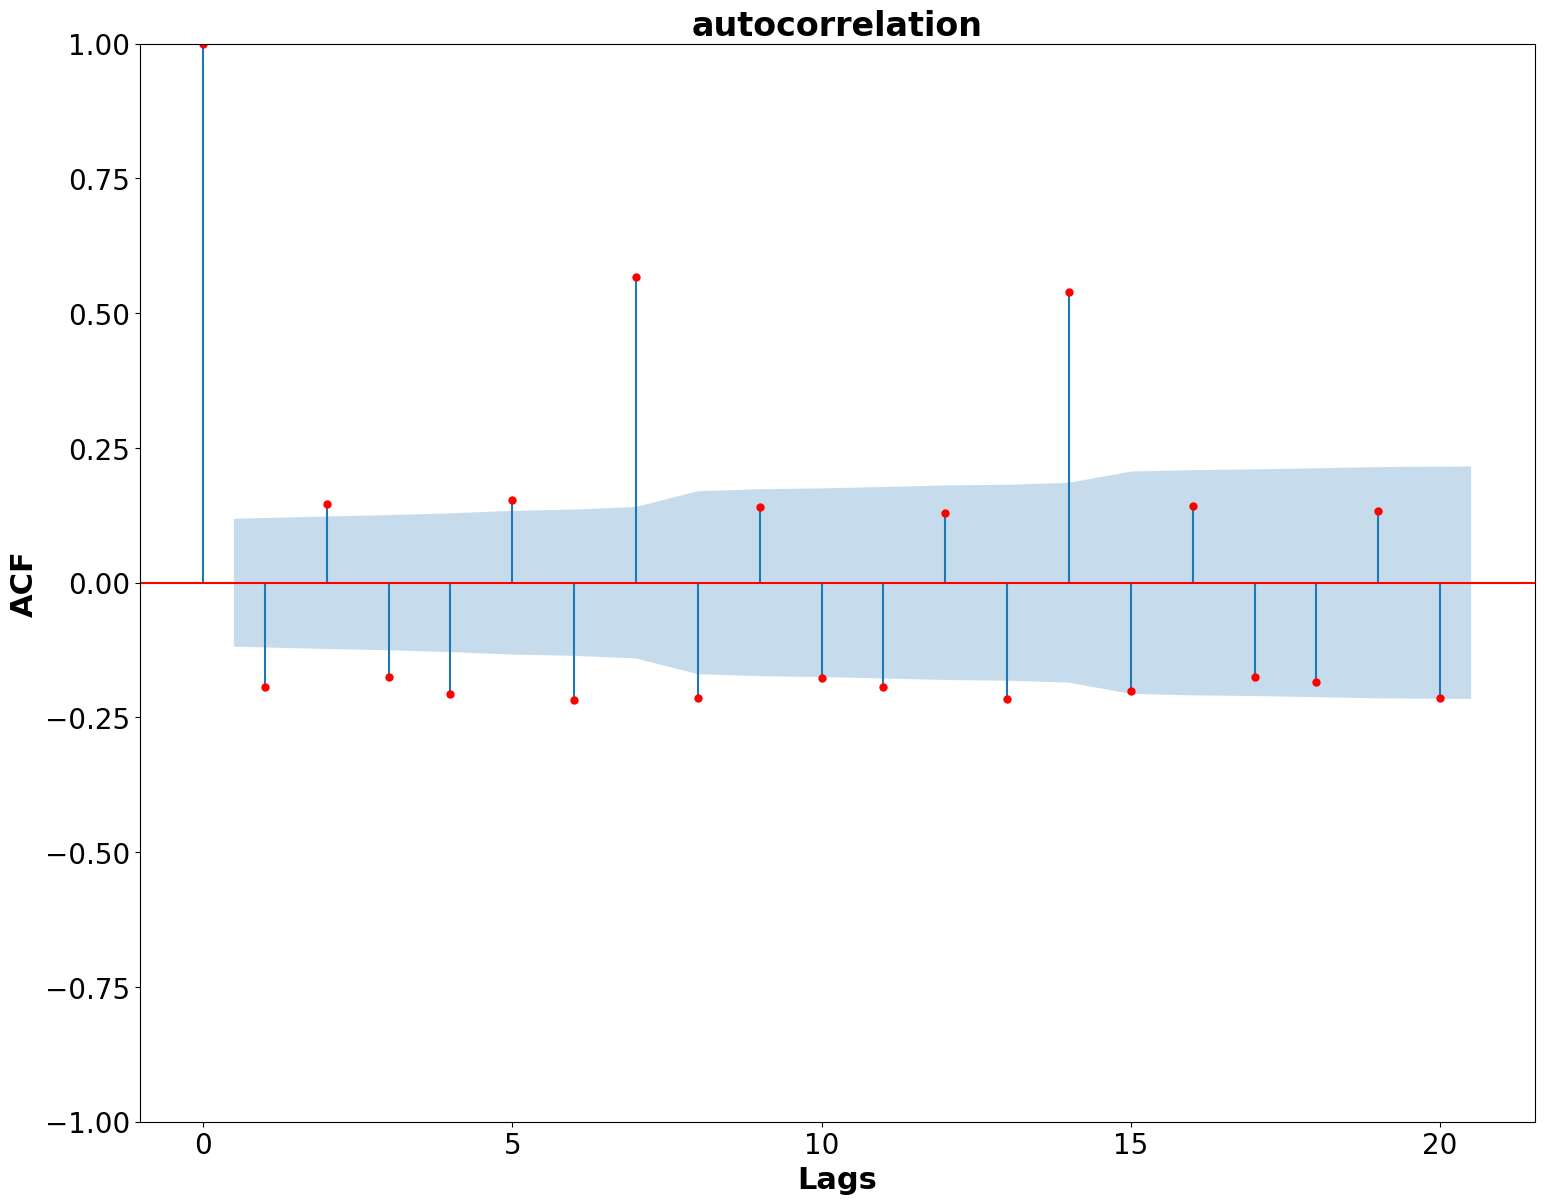

In [7]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

lags = len(df_by_day) - 1

fig, ax = plt.subplots(figsize=(18,14))
plot_acf(df_by_day["new_cases"], ax=ax, alpha=0.05, lags=20, color ="red")  # alpha=0.05 for 95% confidence interval
plt.xlabel("Lags",fontsize=22,weight ='bold')
plt.title('autocorrelation', fontsize =24,weight ='bold')
plt.ylabel('ACF',fontsize =22, weight ='bold')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

plt.show()


### weekly

In [8]:
# lags = len(df_by_week) - 1

# fig, ax = plt.subplots(figsize=(18,4))
# plot_acf(df_by_week["new_cases"], ax=ax, alpha=0.05, lags=30, color ="red")  # alpha=0.05 for 95% confidence interval
# plt.xlabel("Lags")
# plt.show()

there is a possibility of a additive or multiplicative time series.

<b>additive time series:</b>
$ X_t = m_t + S_t +Y_t$

<b>multiplicative time:</b>
$ X_t = m_t * S_t *Y_t$


<Figure size 1800x400 with 0 Axes>

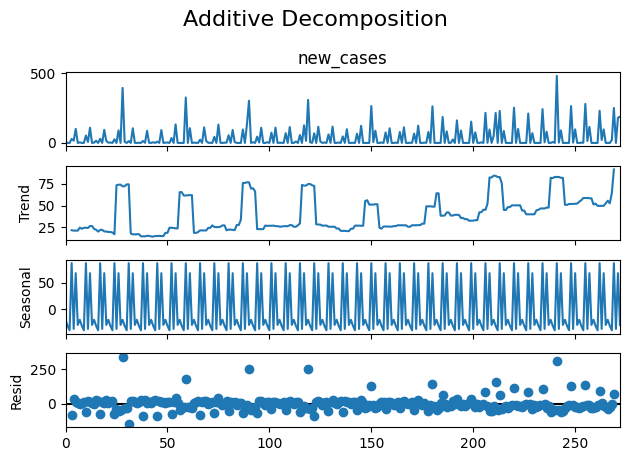

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
# multiplicative_decomposition = seasonal_decompose(df_by_day['new_cases'], model='multiplicative', period=7)


# Additive Decomposition
#daily
additive_decomposition = seasonal_decompose(df_by_day['new_cases'], model='additive', period = 7)


# Plot
# plt.rcParams.update({'figure.figsize': (16,12)})
# multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)

plt.figure(figsize=(18,4))
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 1]) # rect=[left, bottom, right, top]
plt.show()

In [29]:
# #weekly
# additive_decomposition = seasonal_decompose(df_by_week['new_cases'], model='additive', period=4)

# plt.figure(figsize=(18,4))
# additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
# plt.tight_layout(rect=[0, 0.03, 1, 1]) # rect=[left, bottom, right, top]
# plt.show()

There is a consistent peak occurance of in the residuals of the additive decomposition

## stationary and non-stationary time series


![image info](https://www.machinelearningplus.com/wp-content/uploads/2019/02/stationary-and-non-stationary-time-series-865x569.png?ezimgfmt=ng:webp/ngcb1)

image source : https://www.machinelearningplus.com/wp-content/uploads/2019/02/stationary-and-non-stationary-time-series-865x569.png?ezimgfmt=ng:webp/ngcb1


Now we git ti convert the non-stationary sereies into stationary utilizing 
<li> taking the log of the series </li>
<li> the differencing the series </li>


## creating train and test set

In [47]:
# #Creating train and test set 
# #daily
train = df_by_day[0:int(len(df_by_day)*0.95)] 
test= df_by_day[int(len(df_by_day)*0.95):]#Creating train and test set 


# #weekly
# train = df_by_week[0:int(len(df_by_week)*0.80)] 
# test= df_by_week[int(len(df_by_week)*0.80):]#Creating train and test set 



 Training data start at 

        date  new_cases
0 2023-11-02        7.0 ['Year', 'Daily']

 Training data ends at 

          date  new_cases
258 2024-07-17        0.0 ['Year', 'Daily']

 Test data start at 

          date  new_cases
259 2024-07-18        0.0 ['Year', 'Daily']

 Test data ends at 

          date  new_cases
272 2024-07-31      188.0 ['Year', 'Daily']

 Test data ends at 

          date  new_cases
272 2024-07-31      188.0 ['Year', 'Daily']


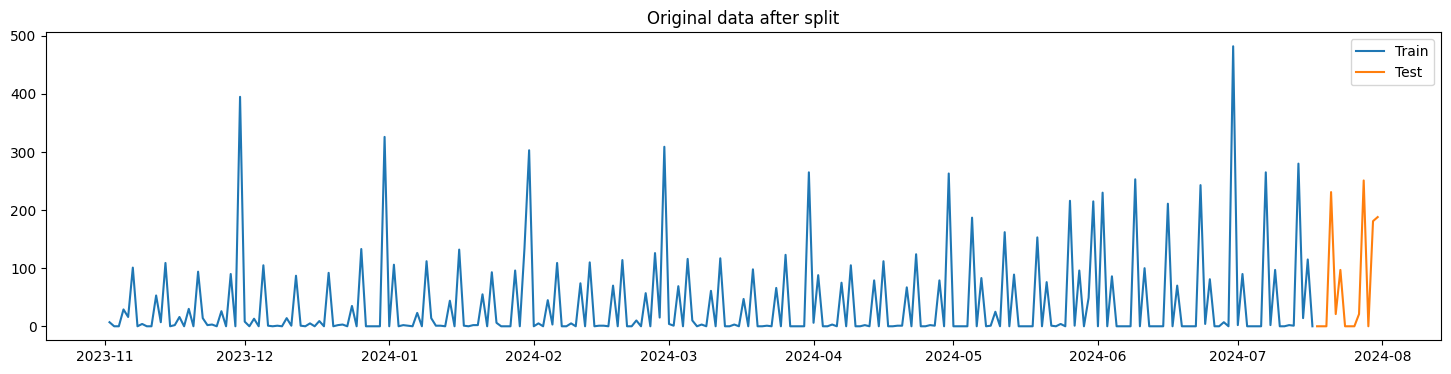

In [48]:
#daily
print("\n Training data start at \n")
print (train[train.date == train.date.min()],['Year','Daily'])
print("\n Training data ends at \n")
print (train[train.date == train.date.max()],['Year','Daily'])

print("\n Test data start at \n")
print (test[test.date == test.date.min()],['Year','Daily'])

print("\n Test data ends at \n")
print (test[test.date == test.date.max()],['Year','Daily'])

print("\n Test data ends at \n")
print (test[test.date == test.date.max()],['Year','Daily'])
plt.figure(figsize=(18,4))
plt.plot(train.date, train.new_cases, label = 'Train')
plt.plot(test.date, test.new_cases,  label = 'Test')
plt.legend(loc = 'best')
plt.title('Original data after split')
plt.show()
# plt.show()

### weekly

In [49]:
# #weekly
# print("\n Training data start at \n")
# print (train[train.week == train.week.min()],['Year','Daily'])
# print("\n Training data ends at \n")
# print (train[train.week == train.week.max()],['Year','Daily'])

# print("\n Test data start at \n")
# print (test[test.week == test.week.min()],['Year','Daily'])

# print("\n Test data ends at \n")
# print (test[test.week == test.week.max()],['Year','Daily'])
# plt.figure(figsize=(18,4))
# plt.plot(train.week, train.new_cases, label = 'Train')
# plt.plot(test.week, test.new_cases,  label = 'Test')
# plt.xticks(rotation = 90)
# plt.legend(loc = 'best')
# plt.title('Original data after split')


## Holt's winter additive method

In [50]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


## fit model
pred = ExponentialSmoothing(np.asarray(train['new_cases']),
                                  seasonal_periods=7, seasonal='add').fit(optimized=True)



print(pred.params)

print('')
print('== Holt-Winters Additive ETS(A,A,A) Parameters ==')
print('')
alpha_value = np.round(pred.params['smoothing_level'], 7)
print('Smoothing Level: ', alpha_value)
print('Smoothing Slope: ', np.round(pred.params['smoothing_trend'], 7))
print('Smoothing Seasonal: ', np.round(pred.params['smoothing_seasonal'], 7))
print('Initial Level: ', np.round(pred.params['initial_level'], 7))
print('Initial Slope: ', np.round(pred.params['initial_trend'], 7))
print('Initial Seasons: ', np.round(pred.params['initial_seasons'], 7))
print('')


### Forecast for next 15 months
y_pred =  pred.forecast(steps = 14)
df_pred = pd.DataFrame({'Y_hat':y_pred,'Y':test['new_cases']})
print(df_pred)

{'smoothing_level': 0.003934243914855308, 'smoothing_trend': nan, 'smoothing_seasonal': 0.19357003796324007, 'damping_trend': nan, 'initial_level': 30.882867283039335, 'initial_trend': nan, 'initial_seasons': array([ 20.51318313, -23.39748141, -27.75910698,  12.85817047,
       -23.10010784,  73.60479456, -22.35726916]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}

== Holt-Winters Additive ETS(A,A,A) Parameters ==

Smoothing Level:  0.0039342
Smoothing Slope:  nan
Smoothing Seasonal:  0.19357
Initial Level:  30.8828673
Initial Slope:  nan
Initial Seasons:  [ 20.5131831 -23.3974814 -27.759107   12.8581705 -23.1001078  73.6047946
 -22.3572692]

          Y_hat      Y
259    4.811797    0.0
260   14.884475    0.0
261    1.352483    0.0
262  259.663468  231.0
263    4.617768   21.0
264   99.045557   97.0
265    1.628509    0.0
266    4.811797    0.0
267   14.884475    0.0
268    1.352483   21.0
269  259.663468  251.0
270    4.617768    0.0
271   99.045557  181.0
272    1.6285

### weekly

In [ ]:
# from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# ## fit model
# pred = ExponentialSmoothing(np.asarray(train['new_cases']),
#                                   seasonal_periods=4, seasonal='additive').fit(optimized=True)



# print(pred.params)

# print('')
# print('== Holt-Winters Additive ETS(A,A,A) Parameters ==')
# print('')
# alpha_value = np.round(pred.params['smoothing_level'], 7)
# print('Smoothing Level: ', alpha_value)
# print('Smoothing Slope: ', np.round(pred.params['smoothing_trend'], 7))
# print('Smoothing Seasonal: ', np.round(pred.params['smoothing_seasonal'], 7))
# print('Initial Level: ', np.round(pred.params['initial_level'], 7))
# print('Initial Slope: ', np.round(pred.params['initial_trend'], 7))
# print('Initial Seasons: ', np.round(pred.params['initial_seasons'], 7))
# print('')


# ### Forecast for next 15 months
# y_pred =  pred.forecast(steps = 8)
# df_pred = pd.DataFrame({'Y_hat':y_pred,'Y':test['new_cases']})
# print(df_pred)

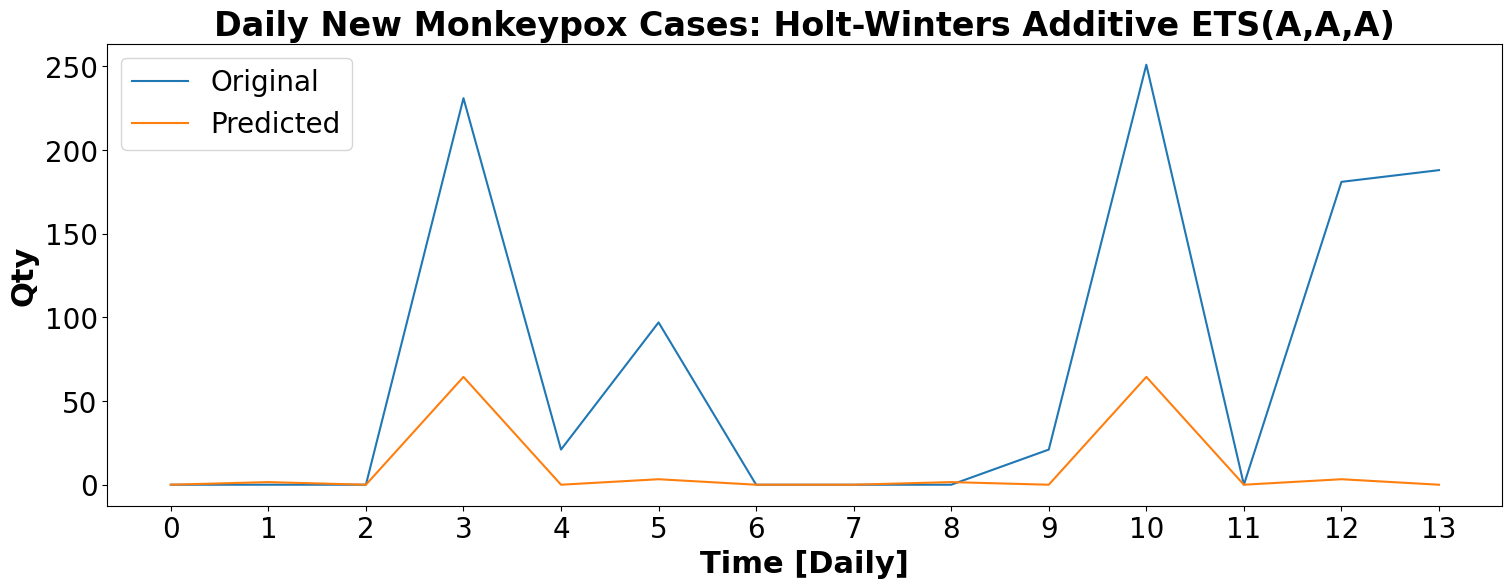

In [82]:
### Plot
fig2, ax = plt.subplots(figsize=(18,6))
ax.plot(test['new_cases'].values, label='Original')
ax.plot(y_pred, label='Predicted')

plt.legend(loc='upper left',fontsize = 20)
plt.title('Daily New Monkeypox Cases: Holt-Winters Additive ETS(A,A,A)', fontsize =24, weight ='bold')
plt.ylabel('Qty', fontsize=22,  weight ='bold')
plt.xlabel('Time [Daily]', fontsize=22, weight ='bold')
plt.xticks(np.arange(len(test), step =1), fontsize =20)
plt.yticks(fontsize =20)
plt.show()


# plt.xlabel("Lags",fontsize=22,weight ='bold')
# plt.title('autocorrelation', fontsize =24,weight ='bold')
# plt.ylabel('ACF',fontsize =22, weight ='bold')
# plt.xticks(fontsize =20)
# plt.yticks(fontsize =20)

In [ ]:
from sklearn.metrics import root_mean_squared_error

df_model_opt =  pd.DataFrame({'Y_hat':y_pred,'Y':test['new_cases'].values})
rmse_opt    =  root_mean_squared_error(df_model_opt.Y, df_model_opt.Y_hat)

print("RMSE is %3.4f" %(rmse_opt))

RMSE is 55.7554


In [ ]:
print(pred.params)

{'smoothing_level': 0.003934243914855308, 'smoothing_trend': nan, 'smoothing_seasonal': 0.19357003796324007, 'damping_trend': nan, 'initial_level': 30.882867283039335, 'initial_trend': nan, 'initial_seasons': array([ 20.51318313, -23.39748141, -27.75910698,  12.85817047,
       -23.10010784,  73.60479456, -22.35726916]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


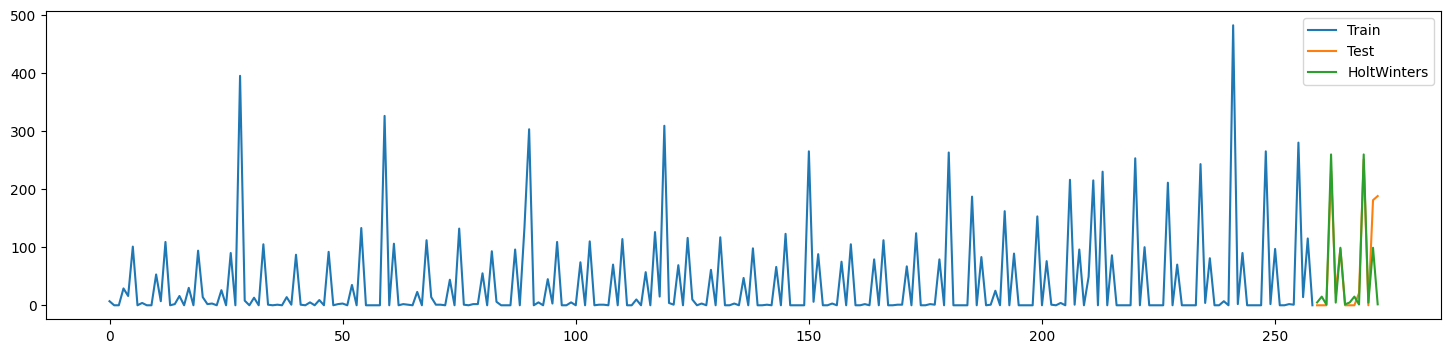

In [ ]:
pred_HoltW = test.copy()


pred_HoltW['HoltW'] = pred.forecast(len(test['new_cases']))
plt.figure(figsize=(18,4))
plt.plot(train['new_cases'], label='Train')
plt.plot(test['new_cases'], label='Test')
plt.plot(pred_HoltW['HoltW'], label='HoltWinters')
# plt.title('Holt-Winters Additive ETS(A,A,A) Parameters:\n  alpha = ' + 
#           str(alpha_value) + '  Beta:' + 
#           str(np.round(pred.params['smoothing_trend'], 7)) +
#           '  Gamma: ' + str(np.round(pred.params['smoothing_seasonal'], 7)))
plt.legend(loc='best')
plt.show()

{'smoothing_level': 0.003934243914855308, 'smoothing_trend': nan, 'smoothing_seasonal': 0.19357003796324007, 'damping_trend': nan, 'initial_level': 30.882867283039335, 'initial_trend': nan, 'initial_seasons': array([ 20.51318313, -23.39748141, -27.75910698,  12.85817047,
       -23.10010784,  73.60479456, -22.35726916]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}



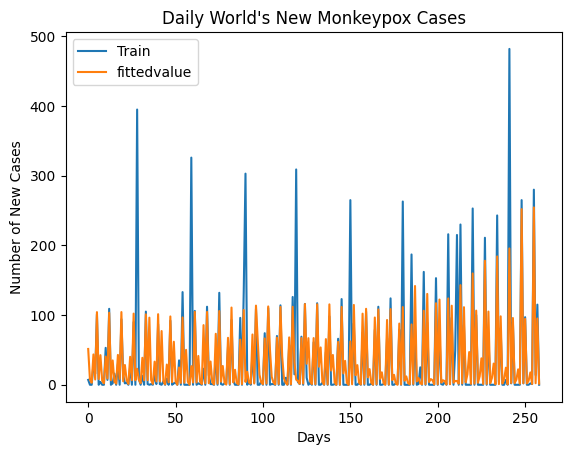

In [ ]:
# Create and fit the model
print(pred.params)
print('')

plt.plot(train['new_cases'], label='Train')
plt.plot(pred.fittedvalues, label='fittedvalue')
plt.ylabel('Number of New Cases')
plt.title("Daily World's New Monkeypox Cases")
plt.xlabel('Days')
plt.legend(loc='best')
plt.show()

In [ ]:
len(test)

14

# RNN LSTM method

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import RootMeanSquaredError

In [31]:
training_set = train.iloc[:,1:].values
testing_set = test.iloc[:,1:].values

In [32]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)


### Creating a data structure with 7 timesteps and 1 output

In [33]:
X_train = []
y_train = []
for i in range(7, len(training_set)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [34]:
X_train.shape

(252, 7, 1)

## Initializing the RNN 

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
regressor = Sequential()


# add the first lstm
regressor.add(LSTM(units =256, return_sequences =True))
regressor.add(Dropout(0.2))
# add the second lstm
regressor.add(LSTM(units = 128, return_sequences =True))
regressor.add(Dropout(0.2))
# add the third lstm
regressor.add(LSTM(units = 64, return_sequences =True))
regressor.add(Dropout(0.2))
# add the fourth lstm
regressor.add(LSTM(units = 32, return_sequences =True))
regressor.add(Dropout(0.2))
# add the fifth lstm
regressor.add(LSTM(units = 16))
regressor.add(Dropout(0.2))
# adding the output layer
regressor.add(Dense(units = 1))

## Compiling the RNN with appropriate optimizer and loss function
import tensorflow as tf
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

regressor.compile(optimizer='adam', loss='mse', metrics=[root_mean_squared_error])

history = regressor.fit(X_train, y_train, epochs=200, batch_size=32
              )



Epoch 1/200
8/8 [==============================] - 9s 27ms/step - loss: 0.0263 - root_mean_squared_error: 0.1571
Epoch 2/200
8/8 [==============================] - 0s 27ms/step - loss: 0.0257 - root_mean_squared_error: 0.1566
Epoch 3/200
8/8 [==============================] - 0s 27ms/step - loss: 0.0249 - root_mean_squared_error: 0.1526
Epoch 4/200
8/8 [==============================] - 0s 27ms/step - loss: 0.0233 - root_mean_squared_error: 0.1458
Epoch 5/200
8/8 [==============================] - 0s 27ms/step - loss: 0.0214 - root_mean_squared_error: 0.1407
Epoch 6/200
8/8 [==============================] - 0s 27ms/step - loss: 0.0208 - root_mean_squared_error: 0.1390
Epoch 7/200
8/8 [==============================] - 0s 27ms/step - loss: 0.0207 - root_mean_squared_error: 0.1390
Epoch 8/200
8/8 [==============================] - 0s 27ms/step - loss: 0.0199 - root_mean_squared_error: 0.1325
Epoch 9/200
8/8 [==============================] - 0s 27ms/step - loss: 0.0211 - root_mean_squar

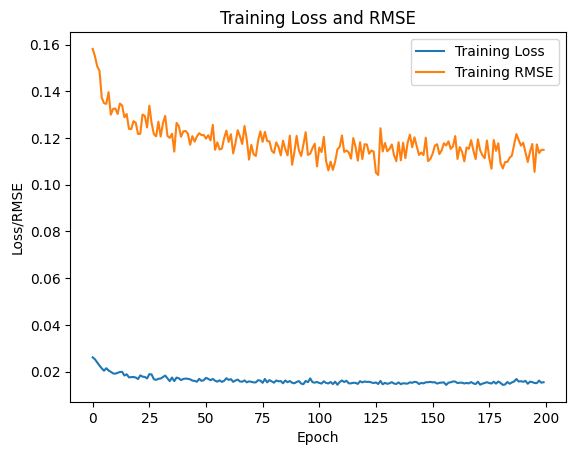

In [ ]:
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
# plt.title('Training Loss and RMSE')
# plt.ylabel('Loss/RMSE')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()

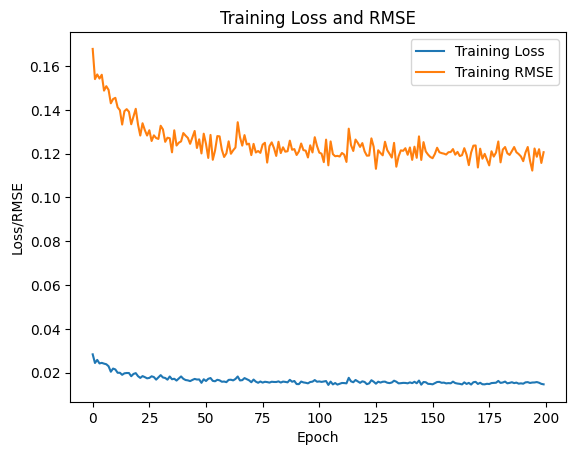

In [ ]:

# # Plot training and validation loss values
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
# plt.title('Training Loss and RMSE')
# plt.ylabel('Loss/RMSE')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()

In [ ]:
# history.history['loss']

[0.014596106484532356,
 0.015903208404779434,
 0.01522820070385933,
 0.015155346132814884,
 0.015728630125522614,
 0.01463276892900467,
 0.014532789587974548,
 0.014764495193958282,
 0.014863856136798859,
 0.01505720242857933,
 0.014576748013496399,
 0.01588052324950695,
 0.015418948605656624,
 0.015022828243672848,
 0.014511099085211754,
 0.015560515224933624,
 0.015315134078264236,
 0.015610839240252972,
 0.015063039027154446,
 0.014924920164048672,
 0.014815888367593288,
 0.01547983754426241,
 0.015926238149404526,
 0.01508416049182415,
 0.015435532666742802,
 0.016224706545472145,
 0.015000651590526104,
 0.015999536961317062,
 0.015078254044055939,
 0.016065040603280067,
 0.014599277637898922,
 0.014690672047436237,
 0.016112321987748146,
 0.015782656148076057,
 0.01526759285479784,
 0.015277095139026642,
 0.015425917692482471,
 0.01521780714392662,
 0.014714210294187069,
 0.015066700056195259,
 0.01580437272787094,
 0.015250202268362045,
 0.015054682269692421,
 0.01444441452622413

### pickle a model

In [55]:
# import pickle
# # save the model to disk
# filename = 'rnn_lstm_monkeypox_newcases.sav'
# pickle.dump(regressor, open(filename, 'wb'))

NameError: name 'regressor' is not defined

### load the model from disk

In [41]:
import pickle
regressor = pickle.load(open('rnn_lstm_monkeypox_newcases.sav', 'rb'))

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2024-11-04 11:03:02         5961
metadata.json                                  2024-11-04 11:03:02           64
variables.h5                                   2024-11-04 11:03:02      6373432
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\dropout_3
......vars
...layers\dropout_4
......vars
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...layers\lstm_2
......vars
...layers\lstm_2\cell
......vars
.........0
.........1
.........2
...layers\lstm_3
......vars
...layers\lstm_3\cell
......vars
.........0
.........1
.........2
...layers\l

## make predictions and visualizing the results

In [57]:
dataset_total = pd.concat((train['new_cases'], test['new_cases']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testing_set) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])
# reshape the test data and make prediction for the monkey new cases
X_test= np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# make predictions on the test data
y_preds = regressor.predict(X_test)

# inverse transform tthe minmaxscaler
y_preds = sc.inverse_transform(y_preds)

1/1 [==============================] - 0s 26ms/step


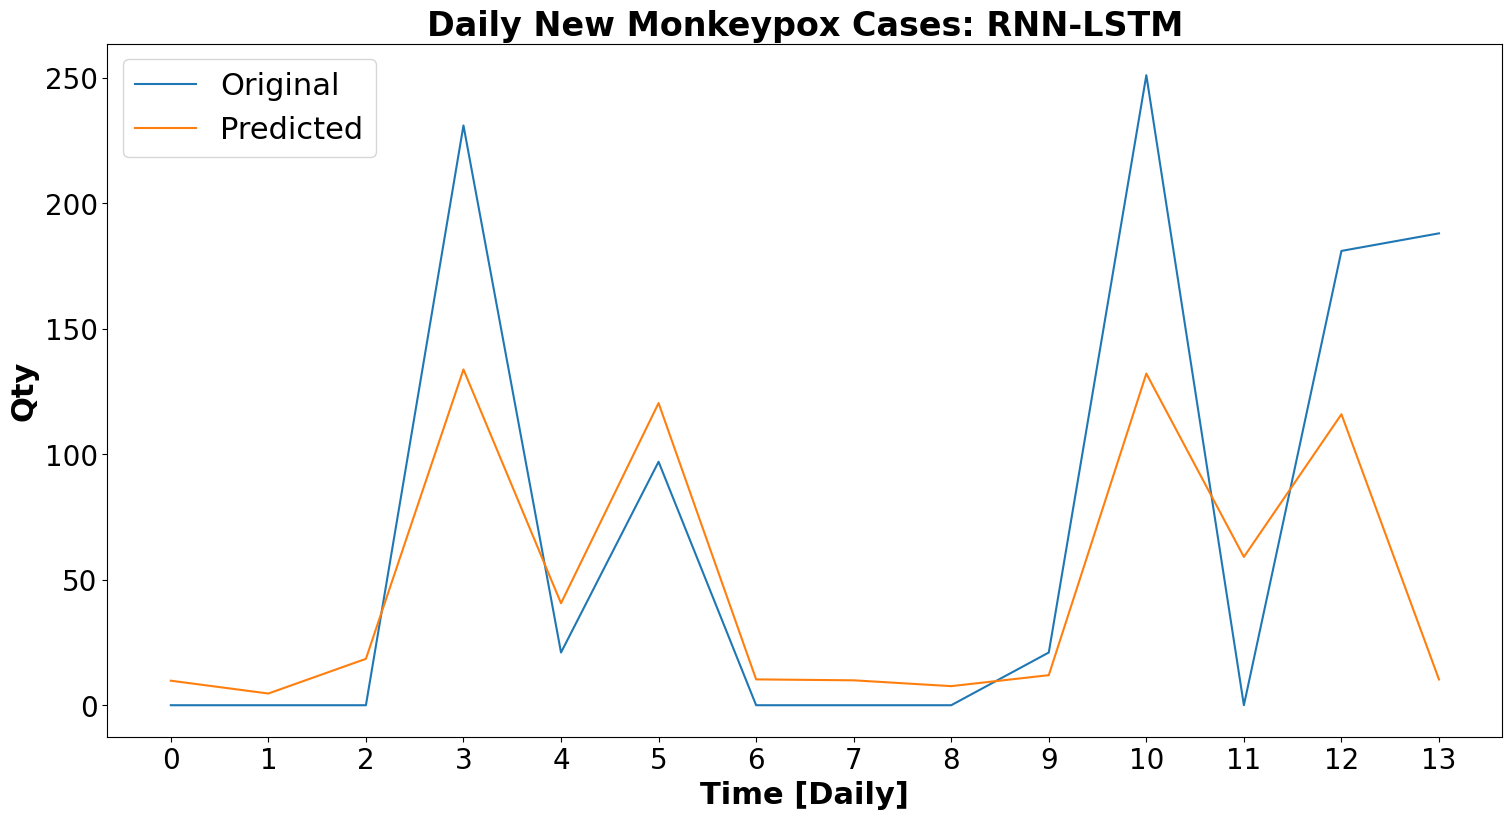

In [65]:

fig2, ax = plt.subplots(figsize=(18,9))
# # Plot the actual values
ax.plot(testing_set, label='Original')
# # Plot the predicted values
ax.plot(y_preds, label='Predicted')
# # Add legend
plt.legend(loc='upper left',fontsize =22)
# # Add title and labels
plt.title('Daily New Monkeypox Cases: RNN-LSTM', fontsize =24,  weight ='bold')
plt.ylabel('Qty', fontsize=22,  weight ='bold')
plt.xlabel('Time [Daily]', fontsize=22, weight ='bold')
plt.xticks(np.arange(len(testing_set), step =1), fontsize =20)
plt.yticks(fontsize =20)
# plt.show()
plt.show()



In [59]:
from sklearn.metrics import root_mean_squared_error

df_model_opt =  pd.DataFrame({'Y_hat':y_preds.flatten(),'Y':test['new_cases'].values})
rmse_opt    =  root_mean_squared_error(df_model_opt.Y, df_model_opt.Y_hat)

print("RMSE is %3.4f" %(rmse_opt))

RMSE is 67.9468


In [60]:
y_pred_train = regressor.predict(X_train)
y_pred_train =sc.inverse_transform(y_pred_train)

8/8 [==============================] - 0s 8ms/step


In [61]:
len(train)

259

## Comparsion of Actual Train Data vs. Fitted Data.

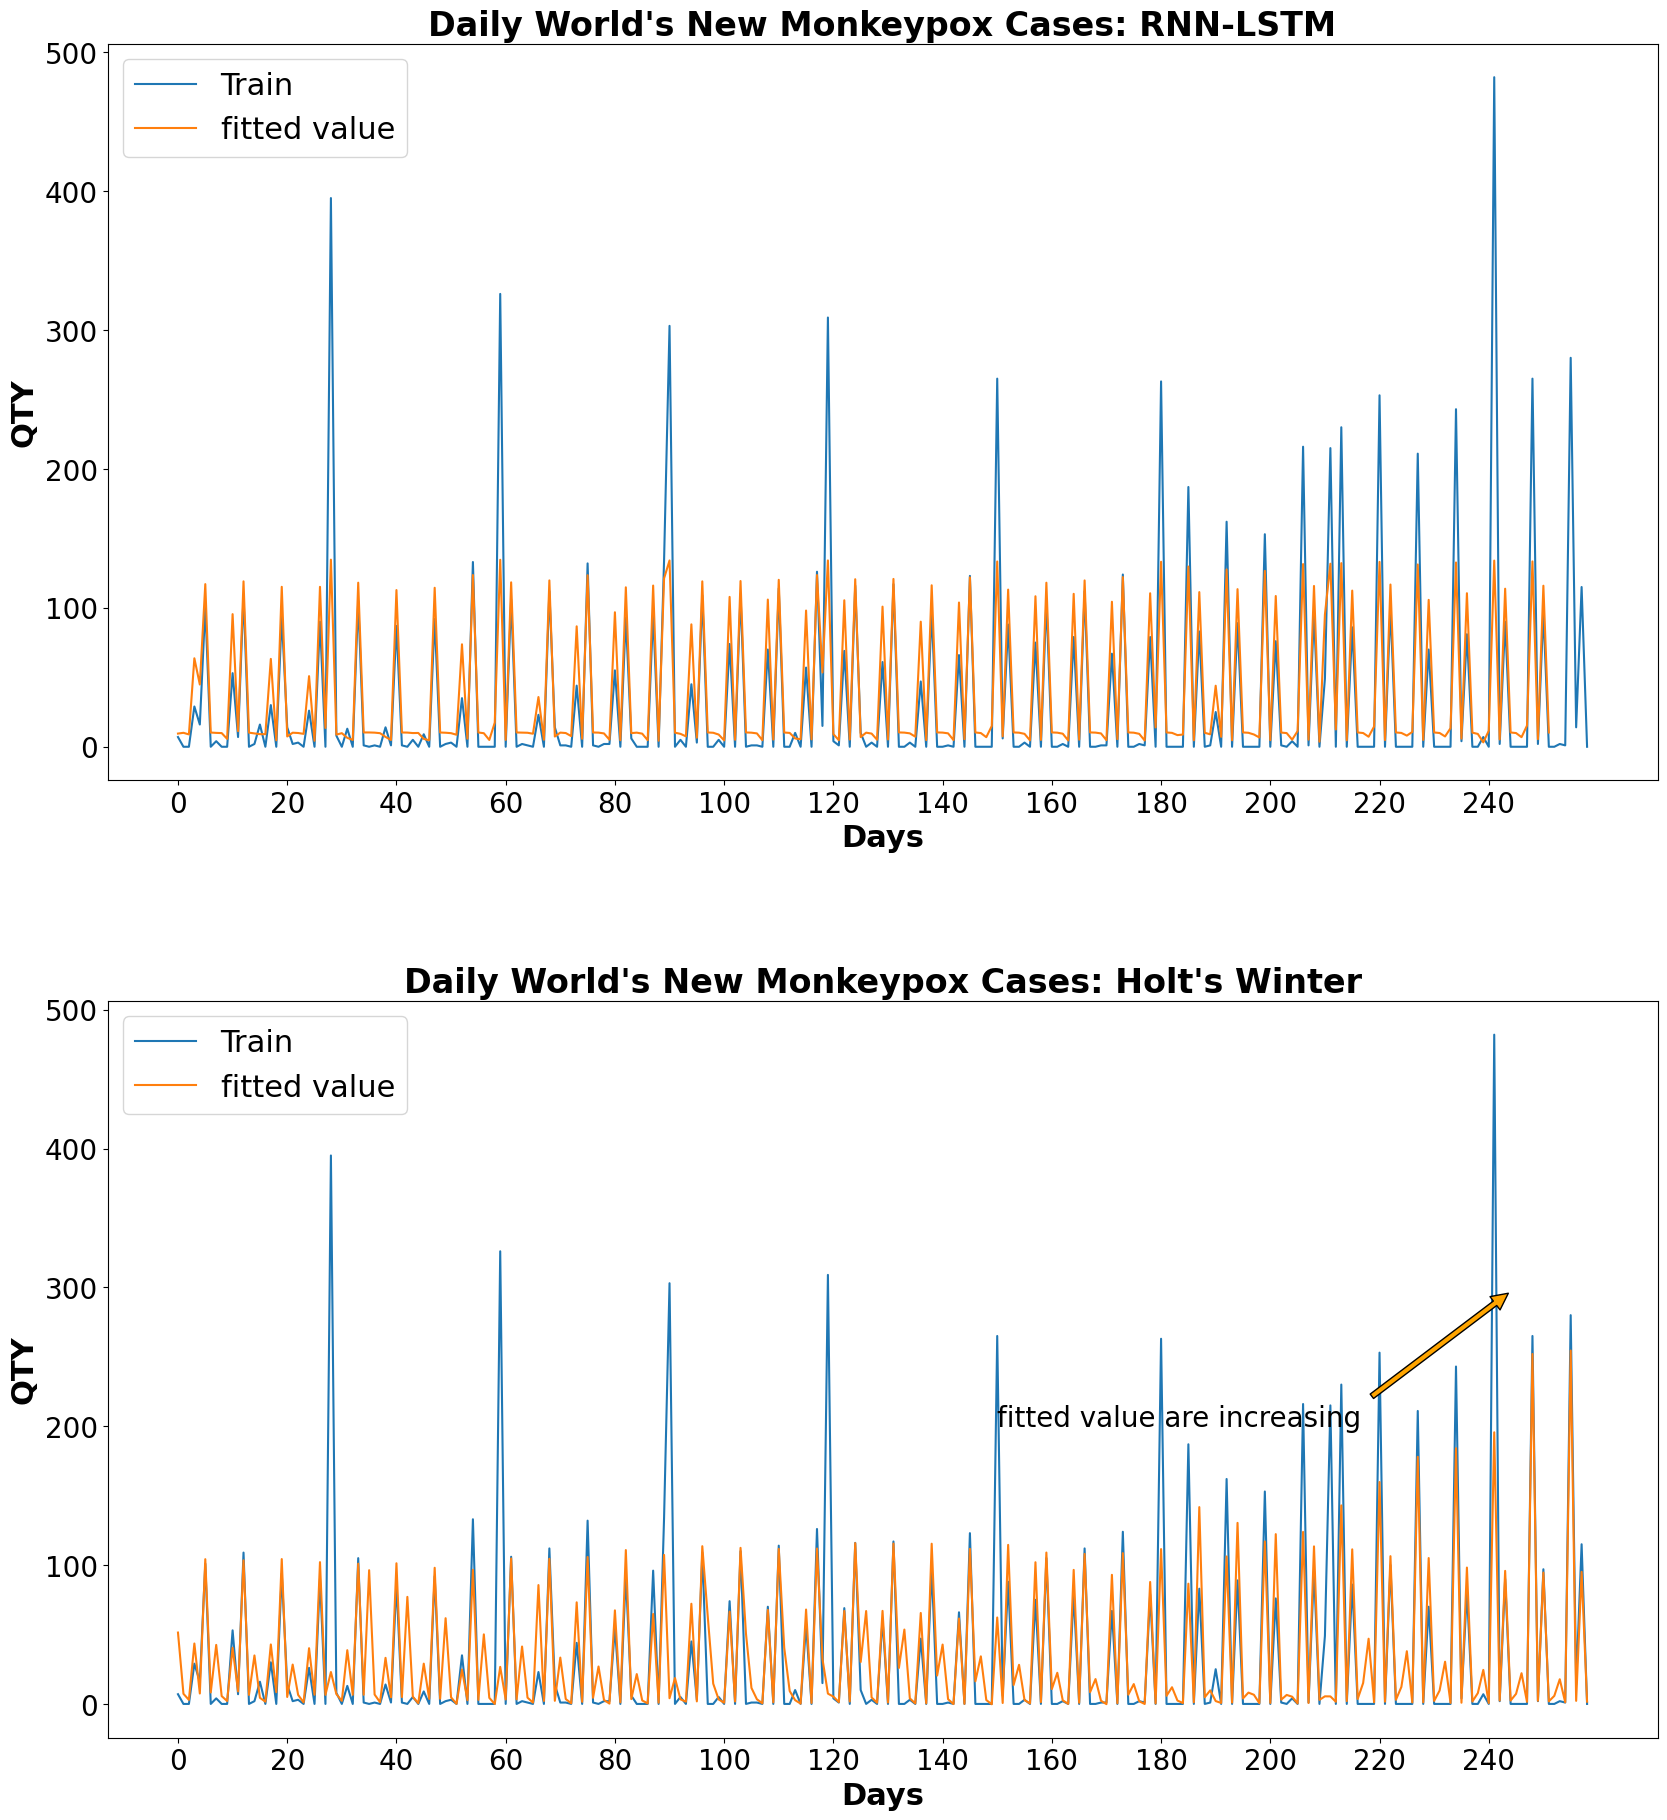

In [78]:

# # Create and fit the model
# print(pred.params)
# print('')

# plt.plot(train['new_cases'], label='Train')
# plt.plot(y_pred_train, label='fittedvalue')
# plt.ylabel('QTY')
# plt.suptitle("RNN-LSTM")
# plt.title("Daily World's New Monkeypox Cases")

# plt.xlabel('Days')
# plt.legend(loc='best')
# plt.show()



fig, axs = plt.subplots(2, 1, figsize=(20, 22), gridspec_kw={'hspace': 0.3})

# Plot on axs[0] and axs[1]
axs[0].plot(train['new_cases'], label='Train')
axs[0].plot(y_pred_train, label='fitted value')
axs[0].set_title("Daily World's New Monkeypox Cases: RNN-LSTM", fontsize=24, fontweight='bold')
axs[0].set_xlabel("Days", fontweight='bold', fontsize=22)
axs[0].set_ylabel("QTY", fontweight='bold', fontsize=22)
axs[0].legend(loc='best', fontsize=22)
axs[0].set_xticks(np.arange(len(training_set), step =20))
axs[0].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)

axs[1].plot(train['new_cases'], label='Train')
axs[1].plot(pred.fittedvalues, label='fitted value')
axs[1].set_title("Daily World's New Monkeypox Cases: Holt's Winter", fontsize=24, fontweight='bold')
axs[1].set_xlabel('Days', fontweight='bold', fontsize=22)
axs[1].set_xticks(np.arange(len(training_set), step =20))
axs[1].tick_params(axis='x', labelsize=20)
axs[1].tick_params(axis='y', labelsize=20)
axs[1].set_ylabel("QTY", fontweight='bold', fontsize=22)
axs[1].legend(loc='best', fontsize =22)

axs[1].annotate('fitted value are increasing', xy=(245, 300), xytext=(150, 200),
            arrowprops=dict(facecolor='orange', shrink=0.05), fontsize =20
            )
plt.show()




In [ ]:
#rnn-lstm
root_mean_squared_error(train['new_cases'][:252], y_pred_train)


In [84]:
#holt's additive
root_mean_squared_error(train['new_cases'], pred.fittedvalues)


55.09149689084047